## Import Libraries

In [1]:
from datasets import load_dataset, DatasetDict
import json
from torch.utils.data import Dataset, DataLoader
from transformers import AutoProcessor
from typing import Dict, List, Any
import random
import lightning as L
import torch
from torch.utils.data import DataLoader
import re
from nltk import edit_distance
import numpy as np
from transformers import PaliGemmaForConditionalGeneration
from transformers import BitsAndBytesConfig
from peft import get_peft_model, LoraConfig
import accelerate
from lightning.pytorch.callbacks import Callback
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from torch.optim.lr_scheduler import CosineAnnealingLR
from lightning.pytorch.callbacks import LearningRateMonitor  
from huggingface_hub import HfApi

In [2]:
REPO_ID = "google/paligemma-3b-pt-224"
FINETUNED_MODEL_ID = "gokulsabari/paligemma-brain-xray"
MAX_LENGTH = 512
WANDB_PROJECT = "paligemma"
WANDB_NAME = "brain-xray-demo"

## Dataset Loading

In [3]:
dataset = load_dataset("gokulsabari/brain-xray")

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'id', 'caption', 'ground_truth'],
        num_rows: 161130
    })
    test: Dataset({
        features: ['image', 'id', 'caption', 'ground_truth'],
        num_rows: 500
    })
})

## Viewing the image

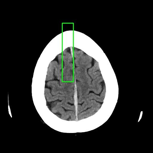

In [5]:
example = dataset["train"][0]
image = example["image"]
width, height = image.size
image = image.resize((int(0.3*width), int(0.3*height)))
image

## Text preprocessing to load  the answer as json. 

In [6]:
def fix_json_string(json_str):
    # Replace single quotes with double quotes for the outer structure
    json_str = json_str.replace("'", '"')
    
    # Find the "answer" field and escape its internal double quotes
    pattern = r'"answer"\s*:\s*"(.*?)"(?=\s*\})'
    
    def escape_quotes(match):
        # Use regular string formatting instead of f-string
        return '"answer": "{}"'.format(match.group(1).replace('"', '\\"'))
    
    fixed_json = re.sub(pattern, escape_quotes, json_str, flags=re.DOTALL)
    
    return fixed_json

## Ground Truth Answer

In [7]:
ground_truth = example["ground_truth"]
ground_truth = ground_truth.replace('\n', ' ').replace('  ', ' ')
ground_truth = fix_json_string(ground_truth)
ground_truth = json.loads(ground_truth)
ground_truth

{'gt_parse': {'question': 'Analyze the provided medical brain imaging scan. Describe the type of scan, key anatomical structures visible, and any abnormal findings. Focus on: Identifying the imaging modality (e.g., CT, MRI) Describing the view and orientation of the scan Noting any visible anatomical structures Identifying and describing any abnormalities or areas of concern Specifying the location of abnormalities using anatomical terms Suggesting possible clinical implications of the findings Provide a concise yet comprehensive analysis in a professional medical tone.',
  'answer': 'The image is a non-contrasted computed tomography (CT) scan of the brain, showing the cerebral structures without any medical devices present. The region of interest, located centrally and in the middle of the image, exhibits an area of altered density, which is indicative of a brain hemorrhage. This area is distinct from the surrounding brain tissue, suggesting a possible hematoma or bleeding within the 

In [8]:
isinstance(ground_truth["gt_parse"], dict)

True

### Create a Pytorch Dataset

In [9]:
class CustomDataset(Dataset):
    def __init__(self, 
                dataset_name: str,
                split: str = "train",
                sort_json_key: bool = True):
        super().__init__()
        self.split = split
        self.sort_json_key = sort_json_key
        self.dataset = load_dataset(path=dataset_name, split=self.split)
        self.dataset_length = len(self.dataset)

        self.gt_token_sequences = []
        for sample in self.dataset:
            ground_truth = sample["ground_truth"]
            ground_truth = ground_truth.replace('\n', ' ')
            ground_truth = fix_json_string(ground_truth)
            ground_truth = json.loads(ground_truth)
            if "gt_parses" in ground_truth:  
                assert isinstance(ground_truth["gt_parses"], list)
                gt_jsons = ground_truth["gt_parses"]
            else:
                assert "gt_parse" in ground_truth and isinstance(ground_truth["gt_parse"], dict)
                gt_jsons = [ground_truth["gt_parse"]]

            
            self.gt_token_sequences.append(
                [
                    self.json2token(
                        gt_json,
                        sort_json_key=self.sort_json_key,
                    )
                    for gt_json in gt_jsons  # load json from list of json
                ]
            )

    def json2token(self, obj: Any, sort_json_key: bool = True):
        """
        Convert an ordered JSON object into a token sequence
        """
        if type(obj) == dict:
            if len(obj) == 1 and "text_sequence" in obj:
                return obj["text_sequence"]
            else:
                output = ""
                if sort_json_key:
                    keys = sorted(obj.keys(), reverse=True)
                else:
                    keys = obj.keys()
                for k in keys:
                    output += (
                        fr"<s_{k}>"
                        + self.json2token(obj[k], sort_json_key)
                        + fr"</s_{k}>"
                    )
                return output
        elif type(obj) == list:
            return r"<sep/>".join(
                [self.json2token(item, sort_json_key) for item in obj]
            )
        else:
            obj = str(obj)
            return obj

    def __len__(self) -> int:
        return self.dataset_length

    def __getitem__(self, idx: int) -> Dict:
        """
        Returns one item of the dataset.

        Returns:
            image : the original Receipt image
            target_sequence : tokenized ground truth sequence
        """
        sample = self.dataset[idx]

        # inputs
        image = sample["image"]
        target_sequence = random.choice(self.gt_token_sequences[idx])  

        return image, target_sequence

In [10]:
train_dataset = CustomDataset(dataset_name="gokulsabari/brain-xray", split="train")
test_dataset = CustomDataset(dataset_name="gokulsabari/brain-xray", split="test")

### Create Collate function

In [11]:
PROMPT = """Analyze the provided medical brain imaging scan. Describe the type of scan, key anatomical structures visible, and any abnormal findings. Focus on: Identifying the imaging modality (e.g., CT, MRI) Describing the view and orientation of the scan Noting any visible anatomical structures Identifying and describing any abnormalities or areas of concern Specifying the location of abnormalities using anatomical terms Suggesting possible clinical implications of the findings Provide a concise yet comprehensive analysis in a professional medical tone."""

pattern = r'(<s_answer>.*?</s_answer>)'


def train_collate_fn(examples):
    images = [example[0] for example in examples]
    texts = [PROMPT for _ in range(len(images))]

    labels = []      # The answer file contains <s_question>question</s_question><s_answer>answer</s_question>. 
                     # We only need <s_answer>answer</s_question>
                     # Used regex to extract only the answer part

    for example in examples:
        label = example[1]
        match = re.search(pattern, label, re.DOTALL)
    
        if match:
            label = match.group(1)
        labels.append(label)

    
    inputs = processor(text=texts, images=images, suffix=labels, return_tensors="pt", padding=True,
                     truncation="only_second", max_length=MAX_LENGTH,
                     tokenize_newline_separately=False)
    
    input_ids = inputs["input_ids"]
    token_type_ids = inputs["token_type_ids"]
    attention_mask = inputs["attention_mask"]
    pixel_values = inputs["pixel_values"]
    labels = inputs["labels"]
    
    
  

    return input_ids, token_type_ids, attention_mask, pixel_values, labels


def eval_collate_fn(examples):
  images = [example[0] for example in examples]
  texts = [PROMPT for _ in range(len(images))]
  answers = [example[1] for example in examples]

  inputs = processor(text=texts, images=images, return_tensors="pt", padding=True, tokenize_newline_separately=False)

  input_ids = inputs["input_ids"]
  attention_mask = inputs["attention_mask"]
  pixel_values = inputs["pixel_values"]

  return input_ids, attention_mask, pixel_values, answers

## Load the processor
In Vision Language Models (VLMs), the processor plays a crucial role in preparing and transforming both image and text inputs into a format that the model can understand and process. It typically handles tasks such as resizing and normalizing images, tokenizing text, and combining these modalities into a single input representation.

In [13]:
processor = AutoProcessor.from_pretrained(REPO_ID)

In [14]:
train_dataloader = DataLoader(train_dataset, collate_fn=train_collate_fn, batch_size=2, shuffle=True)
input_ids, token_type_ids, attention_mask, pixel_values, labels = next(iter(train_dataloader))

In [15]:
processor.batch_decode(input_ids)

['<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><

In [16]:
val_dataloader = DataLoader(test_dataset, collate_fn=eval_collate_fn, batch_size=2, shuffle=False)
input_ids, attention_mask, pixel_values, answers = next(iter(val_dataloader))

In [17]:
processor.batch_decode(input_ids)

['<image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><ima

## Fine Tuning

In [18]:
class PaliGemmaModelPLModule(L.LightningModule):
    def __init__(self, config, processor, model):
        super().__init__()
        self.config = config
        self.processor = processor
        self.model = model

        self.batch_size = config.get("batch_size")

    def training_step(self, batch, batch_idx):

        input_ids, token_type_ids, attention_mask, pixel_values, labels = batch

        outputs = self.model(input_ids=input_ids,
                                attention_mask=attention_mask,
                                token_type_ids=token_type_ids,
                                pixel_values=pixel_values,
                                labels=labels)
        loss = outputs.loss

        self.log("train_loss", loss)

        return loss

    def validation_step(self, batch, batch_idx, dataset_idx=0):

        input_ids, attention_mask, pixel_values, answers = batch

        # autoregressively generate token IDs
        generated_ids = self.model.generate(input_ids=input_ids, attention_mask=attention_mask,
                                       pixel_values=pixel_values, max_new_tokens=MAX_LENGTH)
        # turn them back into text, chopping of the prompt
        # important: we don't skip special tokens here, because we want to see them in the output
        predictions = self.processor.batch_decode(generated_ids[:, input_ids.size(1):], skip_special_tokens=True)

        scores = []
        for pred, answer in zip(predictions, answers):
            pred = re.sub(r"(?:(?<=>) | (?=</s_))", "", pred)
            scores.append(edit_distance(pred, answer) / max(len(pred), len(answer)))

            if self.config.get("verbose", False) and len(scores) == 1:
                print(f"Prediction: {pred}")
                print(f"    Answer: {answer}")
                print(f" Normed ED: {scores[0]}")

        self.log("val_edit_distance", np.mean(scores))

        return scores

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.config['lr'])
        
        # Calculate total steps
        total_steps = self.config['max_epochs'] * len(self.train_dataloader())
        
        scheduler = CosineAnnealingLR(optimizer, T_max=total_steps)
    
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",  # or "epoch"
                "frequency": 1,
            },
        }

    def train_dataloader(self):
        return DataLoader(train_dataset, collate_fn=train_collate_fn, batch_size=self.batch_size, shuffle=True, num_workers=4)

    def val_dataloader(self):
        return DataLoader(val_dataset, collate_fn=eval_collate_fn, batch_size=self.batch_size, shuffle=False, num_workers=4)

## Training using PEFT (QLoRA)

In [19]:
# Bits and Bytes config

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
)

# LoRA config

lora_config = LoraConfig(
    r=32,                # Higher rank and alpha can be set for complex tasks
    lora_alpha=64,
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"],
    task_type="CAUSAL_LM",
    bias="none",
    lora_dropout=0.05
)

model = PaliGemmaForConditionalGeneration.from_pretrained(REPO_ID, quantization_config=bnb_config, device_map={"":0}, torch_dtype=torch.bfloat16)
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

Unused kwargs: ['bnb_4bit_compute_type']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
C:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\models\paligemma\configuration_paligemma.py:137: FutureWarning: The `vocab_size` attribute is deprecated and will be removed in v4.44, Please use `text_config.vocab_size` instead.
  warnings.warn(
`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

trainable params: 11,298,816 || all params: 2,934,765,296 || trainable%: 0.3850


In [28]:
config = {"max_epochs": 10,
          # "val_check_interval": 0.2, # how many times we want to validate during an epoch
          "check_val_every_n_epoch": 1,
          "gradient_clip_val": 1.0,
          "accumulate_grad_batches": 8,
          "lr": 1e-4,
          "batch_size": 2,
          # "seed":2022,
          "num_nodes": 1,
          "warmup_steps": 50,
          "result_path": "./result",
          "verbose": True,
}

model_module = PaliGemmaModelPLModule(config, processor, model)
lr_monitor = LearningRateMonitor(logging_interval='step')

In [29]:
api = HfApi()

class PushToHubCallback(Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        print(f"Pushing model to the hub, epoch {trainer.current_epoch}")
        pl_module.model.push_to_hub(FINETUNED_MODEL_ID,
                                    commit_message=f"Training in progress, epoch {trainer.current_epoch}")

    def on_train_end(self, trainer, pl_module):
        print(f"Pushing model to the hub after training")
        pl_module.processor.push_to_hub(FINETUNED_MODEL_ID,
                                    commit_message=f"Training done")
        pl_module.model.push_to_hub(FINETUNED_MODEL_ID,
                                    commit_message=f"Training done")

early_stop_callback = EarlyStopping(monitor="val_edit_distance", patience=3, verbose=False, mode="min")

In [ ]:
trainer = L.Trainer(
        accelerator="gpu",
        devices=[0],
        max_epochs=config.get("max_epochs"),
        accumulate_grad_batches=config.get("accumulate_grad_batches"),
        check_val_every_n_epoch=config.get("check_val_every_n_epoch"),
        gradient_clip_val=config.get("gradient_clip_val"),
        precision="16-mixed",
        limit_val_batches=5,
        num_sanity_val_steps=0,
        # logger=wandb_logger,
        callbacks=[PushToHubCallback(), early_stop_callback, lr_monitor],
)

trainer.fit(model_module)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                 | Params | Mode 
-------------------------------------------------------
0 | model | PeftModelForCausalLM | 1.7 B  | train
-------------------------------------------------------
11.3 M    Trainable params
1.